In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


In [11]:
from census_dataset import CensusDataset
from scipy.interpolate import interp1d

def make_predictions_plot(model, county, dataset_kwargs):
    dataset = CensusDataset(county, **dataset_kwargs).validate()
    wb1980 = dataset.wb(1980)
    wb2020 = dataset.wb(2020)

    # Neural network prediction
    batch = dataset[0]
    wb = batch['wb'].to(device)
    housing = batch['housing'][None, None].to(device)
    housing[housing.isnan()] = 0.
    wb[wb.isnan()] = 0.
    with torch.no_grad():
        wbNN = model.simulate(wb[0:1], n_steps=40, dt=1, housing=housing)[0,-1].cpu().numpy()

    # Spline extrapolation
    spline = interp1d([1980, 1990], np.stack([dataset.wb(1980), dataset.wb(1990)]), axis=0, fill_value='extrapolate')
    wbSpline = spline(2020)

    # Make sure we have a common evaluation function to compare models with different input scalings
    # Convert all predictions to units of [1 / dam^2] before calculating error
    if dataset_kwargs['use_fill_frac']:
        err_func = lambda wb0, wb1: np.power(wb0 * dataset.housing - wb1 * dataset.housing, 2).sum(0)[dataset.mask]
    elif dataset_kwargs['use_max_scaling']:
        err_func = lambda wb0, wb1: np.power(wb0 - wb1, 2).sum(0)[dataset.mask] * dataset.housing[dataset.mask].max()**2
    else:
        err_func = lambda wb0, wb1: np.power(wb0 - wb1, 2).sum(0)[dataset.mask]

    mse_NN = np.mean(err_func(wbNN, wb2020))
    mse_Sp = np.mean(err_func(wbSpline, wb2020))
    mse_No = np.mean(err_func(wb1980, wb2020))

    print(f'For county = {county}')
    print(f'---------------------------------')
    print(f'\tModel\t\t|   MSE  ')
    print(f'---------------------------------')
    print(f'Neural Network\t\t|  {mse_NN:.3g}')
    print(f'Spline extrapolation\t|  {mse_Sp:.3g}')
    print(f'No dynamics\t\t|  {mse_No:.3g}')

    alpha = np.ones(dataset.mask.shape)
    alpha[~dataset.mask] = 0.

    def plot(column, dataset, wb):
        vmax = dataset.housing[dataset.mask].max()
        prop = (wb[0] - wb[1]) / wb.sum(0)
        pc0 = column[0].pcolormesh(dataset.x, dataset.y, prop, vmin=-1, vmax=1, cmap='bwr_r', alpha=alpha)
        pc1 = column[1].pcolormesh(dataset.x, dataset.y,  wb[0], vmin=0, vmax=dataset.vmax(), cmap='Blues', alpha=alpha)
        pc2 = column[2].pcolormesh(dataset.x, dataset.y,  wb[1], vmin=0, vmax=dataset.vmax(), cmap='Reds', alpha=alpha)
        return pc0, pc1, pc2

    fig, ax = plt.subplots(3, 4, dpi=200)

    plot(ax[:,0], dataset, wb1980)
    plot(ax[:,1], dataset, wb2020)
    plot(ax[:,2], dataset, wbNN)
    pc0, pc1, pc2 = plot(ax[:,3], dataset, wbSpline)

    plt.rcParams['font.size'] = 8
    plt.rcParams['axes.titlesize'] = 8

    if dataset_kwargs['use_fill_frac']:
        clabel='Fill Fraction'
        ticks=[0,1]
    elif dataset_kwargs['use_max_scaling']:
        clabel='Relative\npopulation density'
        ticks=[0,1]
    else:
        clabel='Population density\n[$1/$dam$^2$]'
        ticks=None

    fig.colorbar(pc0, ax=ax[0,:], ticks=[-1,1]).set_ticklabels(['All\nblack', 'All\nwhite'], 
        rotation=90, verticalalignment='center', multialignment='center')
    fig.colorbar(pc1, ax=ax[1,:], ticks=ticks, label=clabel)
    fig.colorbar(pc2, ax=ax[2,:], ticks=ticks, label=clabel)

    ax[0,0].set_title('1980\ncensus data')
    ax[0,1].set_title('2020\ncensus data')
    ax[0,2].set_title('2020\nNN prediction')
    ax[0,3].set_title('2020\nSpline extrapolation')

    ax[0,0].set_ylabel('Resident\nproportion')
    ax[1,0].set_ylabel('White\noccupation')
    ax[2,0].set_ylabel('Black\noccupation')

    for a in ax.flatten():
        a.set(xticks=[], yticks=[], aspect='equal')

    return fig

In [15]:
import os
import glob
import yaml
import pandas as pd

def report_model(path):
    info = torch.load(f'{path}/model_weight.ckpt', map_location='cpu')

    with open(f'{path}/config.yaml', 'r') as f:
        config = yaml.safe_load(f)

    ret = {
        'path': os.path.basename(path),
        'id': os.path.basename(path).replace('_all_counties', ''),
        'val_loss': info['val_loss'],
        'train_loss': info['train_loss'],
        'val_tmax': config['dataset']['val_tmax'],
        'num_train_counties': len(config['dataset']['train_counties']),
        'housing': config['model']['args']['use_housing']
    }

    dwargs = config['dataset']['kwargs']
    if dwargs['use_fill_frac']:
        ret['objective'] = 'Fill fraction'
    elif dwargs['use_max_scaling']:
        ret['objective'] = 'Relative density'
    else:
        ret['objective'] = 'Absolute density'
    return ret

records = []
for path in glob.glob('models/*'):
    if not os.path.isdir(path): continue
    record = report_model(path)
    if record is not None:
        records.append(record)

df = pd.DataFrame.from_records(records, np.arange(len(records)))
df.sort_values(by=['objective', 'val_loss']).drop(columns='path').set_index(['objective', 'id'])

val_loss  train_loss  val_tmax  \
objective        id                                          
Absolute density 3701409_1  0.009186    0.000157        10   
                 3701409_0  0.009625    0.000150        10   
                 3701261_0  0.009904    0.000163        10   
                 3701258_0  0.010560    0.000156        10   
                 3701375_0  0.011812    0.000240        10   
Fill fraction    3701409_3  0.590489    0.001454        10   
                 3701261_2  0.614066    0.001455        10   
                 3701375_1  0.616078    0.001377        10   
                 3701258_2  0.646703    0.001319        10   
                 3701409_2  0.647295    0.001397        10   
Relative density 3701409_5  0.062450    0.000328        10   
                 3701261_1  0.066285    0.000318        10   
                 3701409_4  0.074218    0.000339        10   
                 3701258_1  0.074592    0.000367        10   
                 3701375_2  0.076484    0.000369        10   

                            num_train_counties  housing  
objective        id                                      
Absolute density 3701409_1                  31     True  
                 3701409_0                  31    False  
                 3701261_0                  31    False  
                 3701258_0                  31    False  
                 3701375_0                  31    False  
Fill fraction    3701409_3                  31     True  
                 3701261_2                  31    False  
                 3701375_1                  31    False  
                 3701258_2                  31    False  
                 3701409_2                  31    False  
Relative density 3701409_5                  31     True  
                 3701261_1                  31    False  
                 3701409_4                  31    False  
                 3701258_1                  31    False  
                 3701375_2                  31    False

## Absolute density model

INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/3701409_1/model_weight.ckpt
INFO:train_census_nn:Model reached loss=0.00919


For county = Georgia_Fulton
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.00116
Spline extrapolation	|  0.00181
No dynamics		|  0.00114
For county = Illinois_Cook
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.00472
Spline extrapolation	|  0.02
No dynamics		|  0.0104
For county = Texas_Harris
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.000959
Spline extrapolation	|  0.00429
No dynamics		|  0.00195
For county = California_Los Angeles
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.00235
Spline extrapolation	|  0.0131
No dynamics		|  0.00374


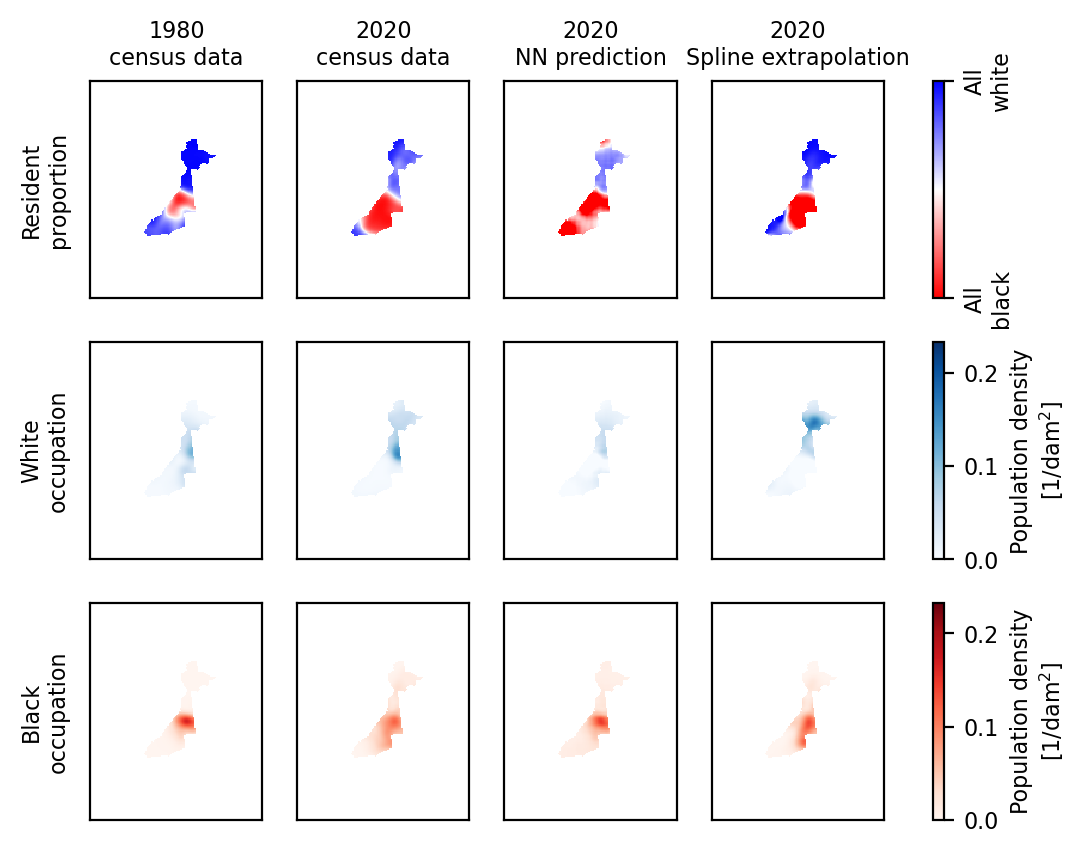

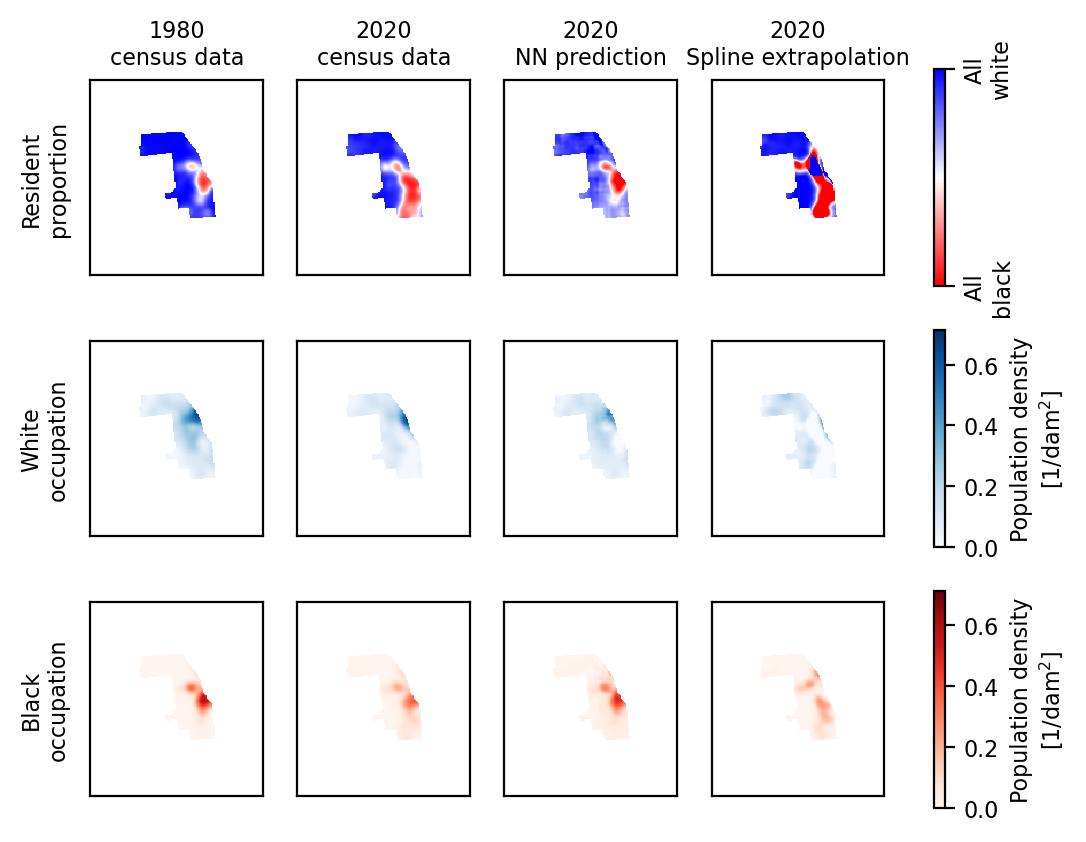

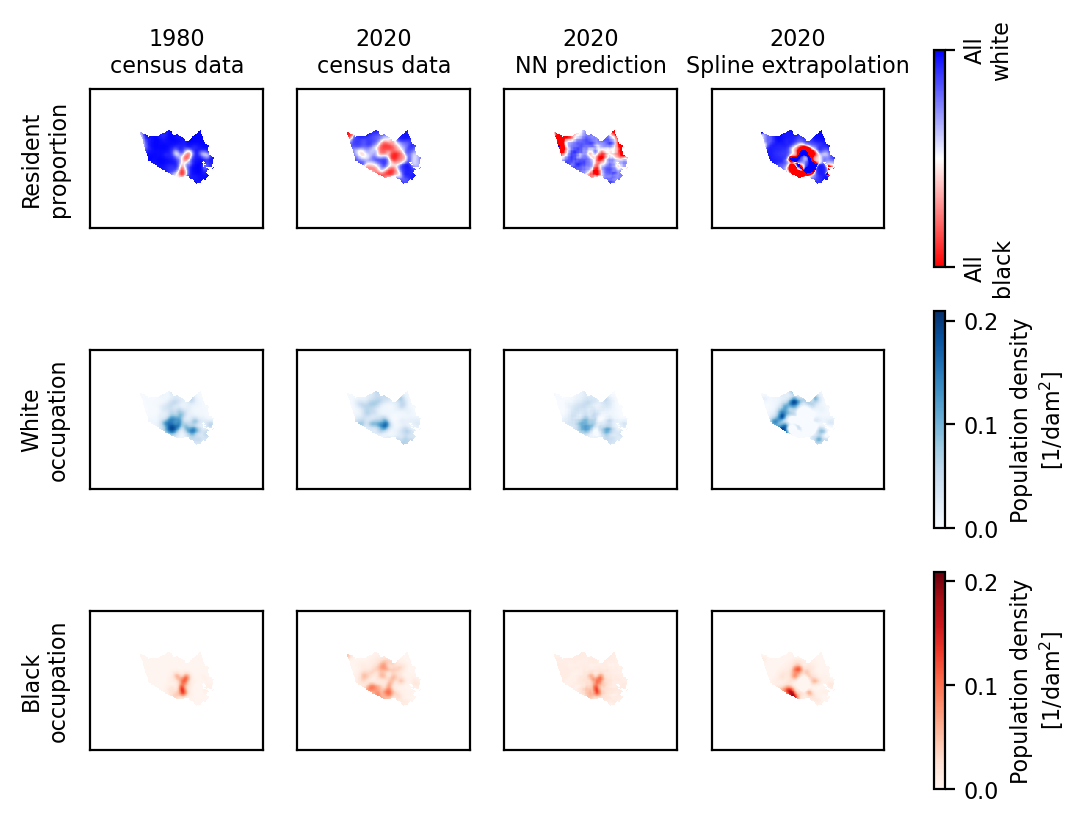

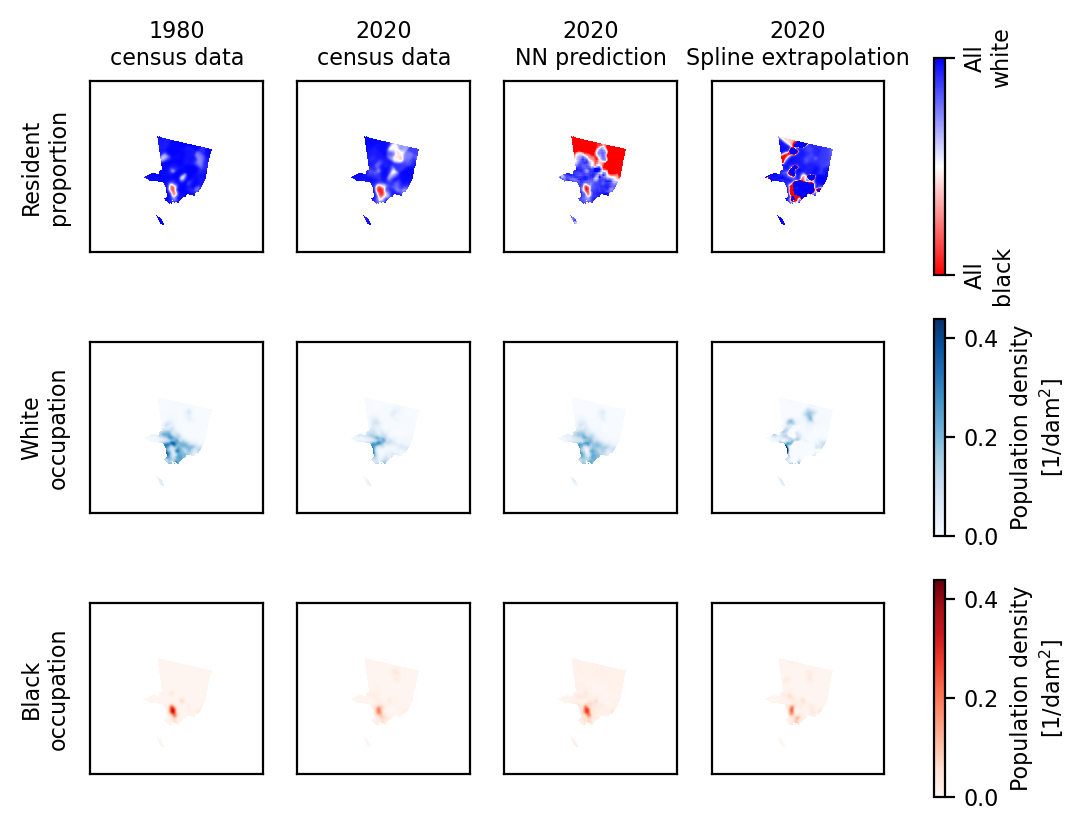

In [12]:
from census_nn import *
from pprint import pprint
import json

sub_df = df[df.objective == 'Absolute density'].reset_index(drop=True)
model = os.path.basename(sub_df.loc[sub_df.val_loss.argmin(), 'path'])

with open(f'models/{model}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

model = get_model(config['model'])
model.to(device)
model.eval();

make_predictions_plot(model, 'Georgia_Fulton', config['dataset']['kwargs']);
make_predictions_plot(model, 'Illinois_Cook', config['dataset']['kwargs']);
make_predictions_plot(model, 'Texas_Harris', config['dataset']['kwargs']);
make_predictions_plot(model, 'California_Los Angeles', config['dataset']['kwargs']);

## Relative density model

INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/3701409_5/model_weight.ckpt
INFO:train_census_nn:Model reached loss=0.0624


For county = Georgia_Fulton
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.000858
Spline extrapolation	|  0.00181
No dynamics		|  0.00114
For county = Illinois_Cook
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.00503
Spline extrapolation	|  0.02
No dynamics		|  0.0104
For county = Texas_Harris
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.00117
Spline extrapolation	|  0.00429
No dynamics		|  0.00195
For county = California_Los Angeles
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.00193
Spline extrapolation	|  0.0131
No dynamics		|  0.00374


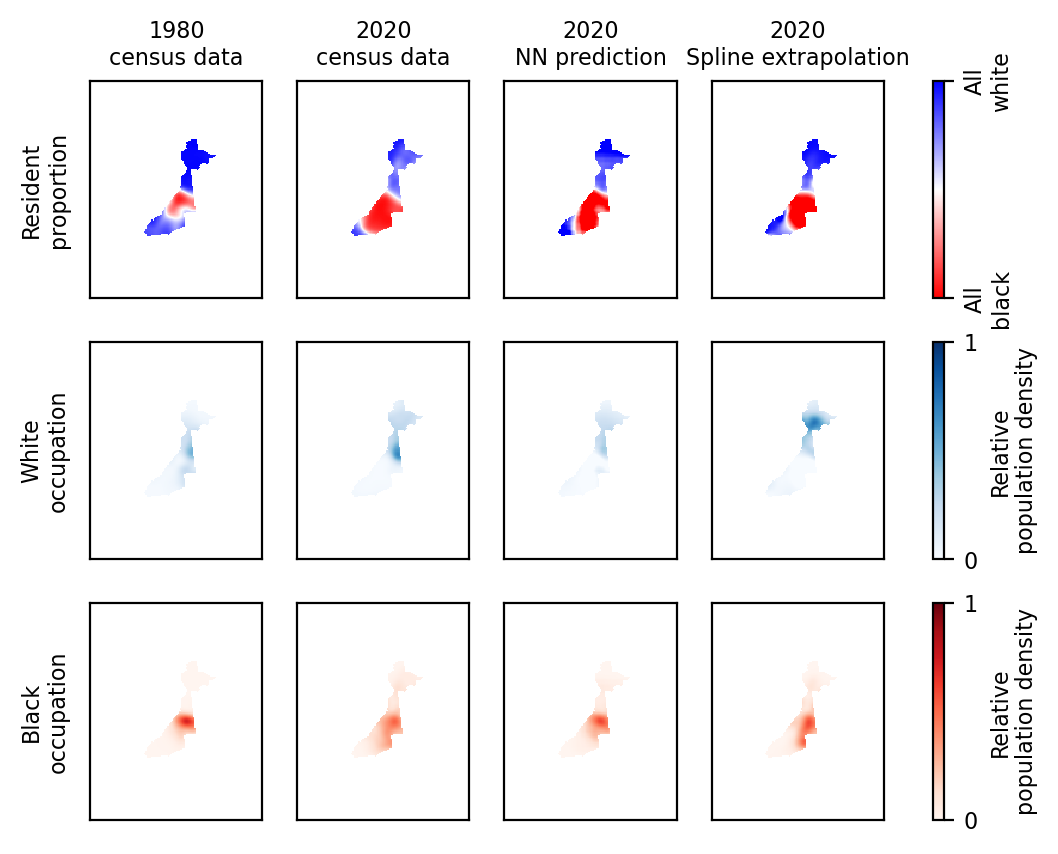

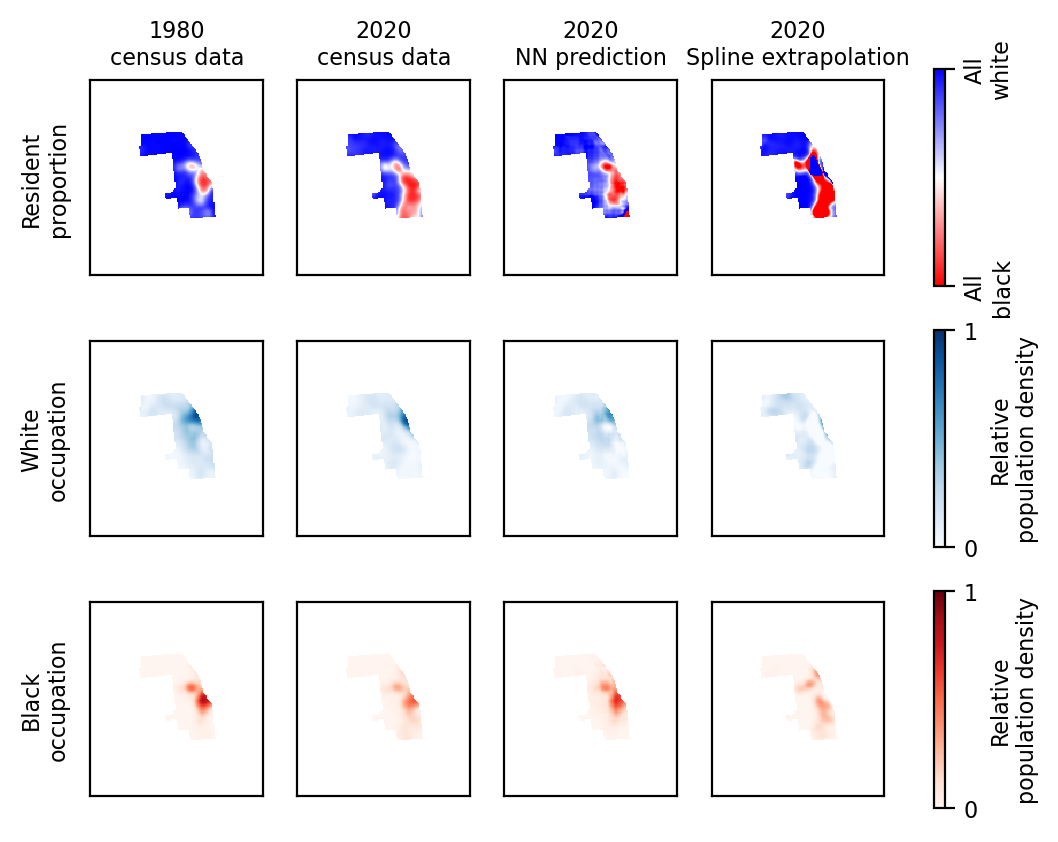

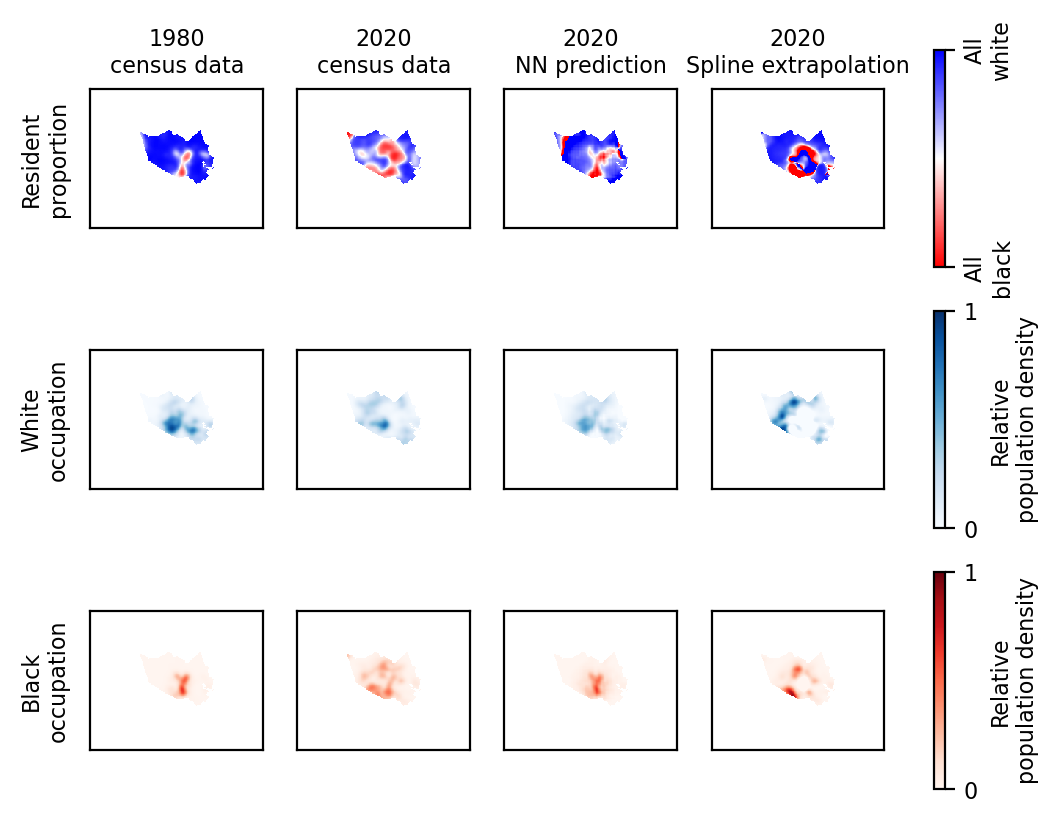

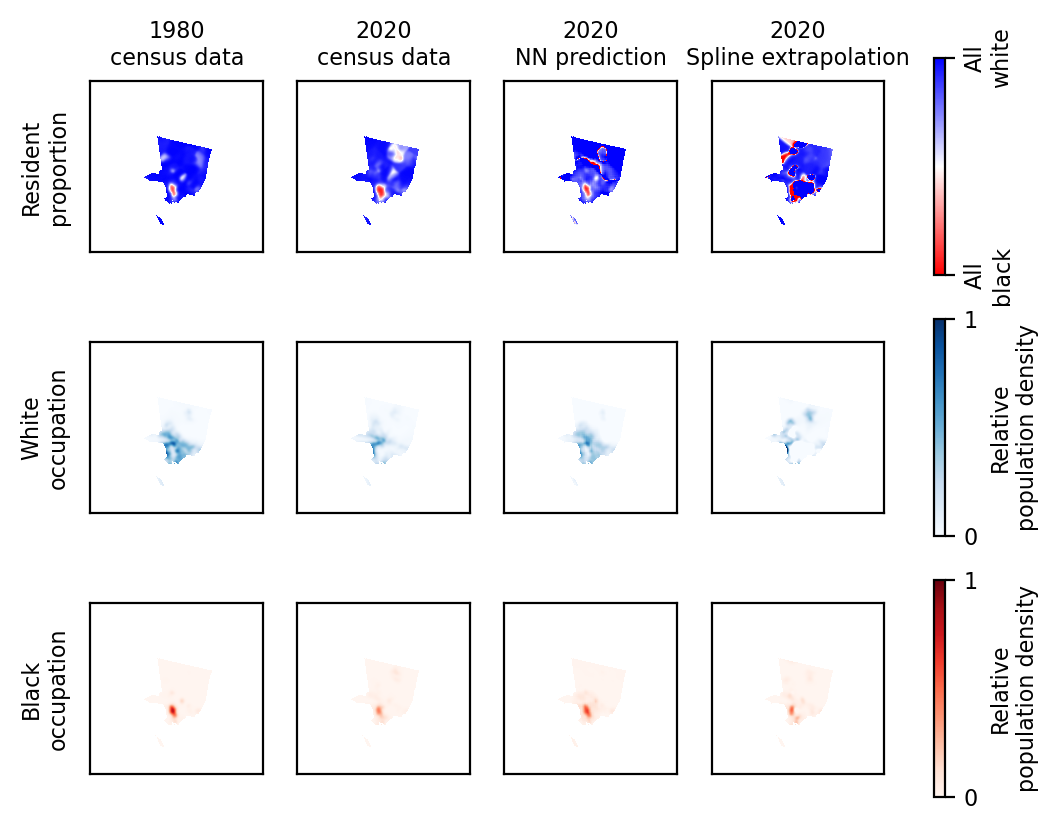

In [13]:
from census_nn import *
from pprint import pprint
import json

sub_df = df[df.objective == 'Relative density'].reset_index(drop=True)
model = os.path.basename(sub_df.loc[sub_df.val_loss.argmin(), 'path'])

with open(f'models/{model}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

model = get_model(config['model'])
model.to(device)
model.eval();

make_predictions_plot(model, 'Georgia_Fulton', config['dataset']['kwargs']);
make_predictions_plot(model, 'Illinois_Cook', config['dataset']['kwargs']);
make_predictions_plot(model, 'Texas_Harris', config['dataset']['kwargs']);
make_predictions_plot(model, 'California_Los Angeles', config['dataset']['kwargs']);

## Fill fraction model

INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/3701409_3/model_weight.ckpt
INFO:train_census_nn:Model reached loss=0.59


For county = Georgia_Fulton
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.00157
Spline extrapolation	|  0.00181
No dynamics		|  0.00114
For county = Illinois_Cook
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.00718
Spline extrapolation	|  0.02
No dynamics		|  0.0104
For county = Texas_Harris
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.00104
Spline extrapolation	|  0.00429
No dynamics		|  0.00195
For county = California_Los Angeles
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.00207
Spline extrapolation	|  0.0131
No dynamics		|  0.00374


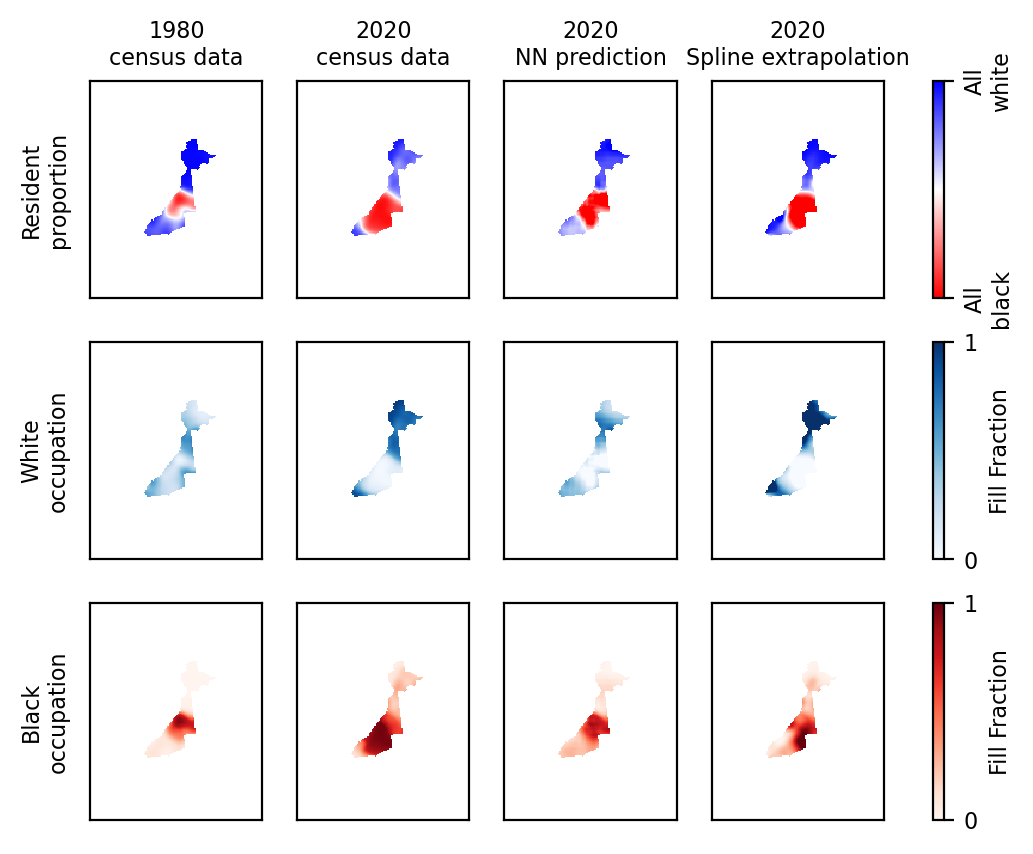

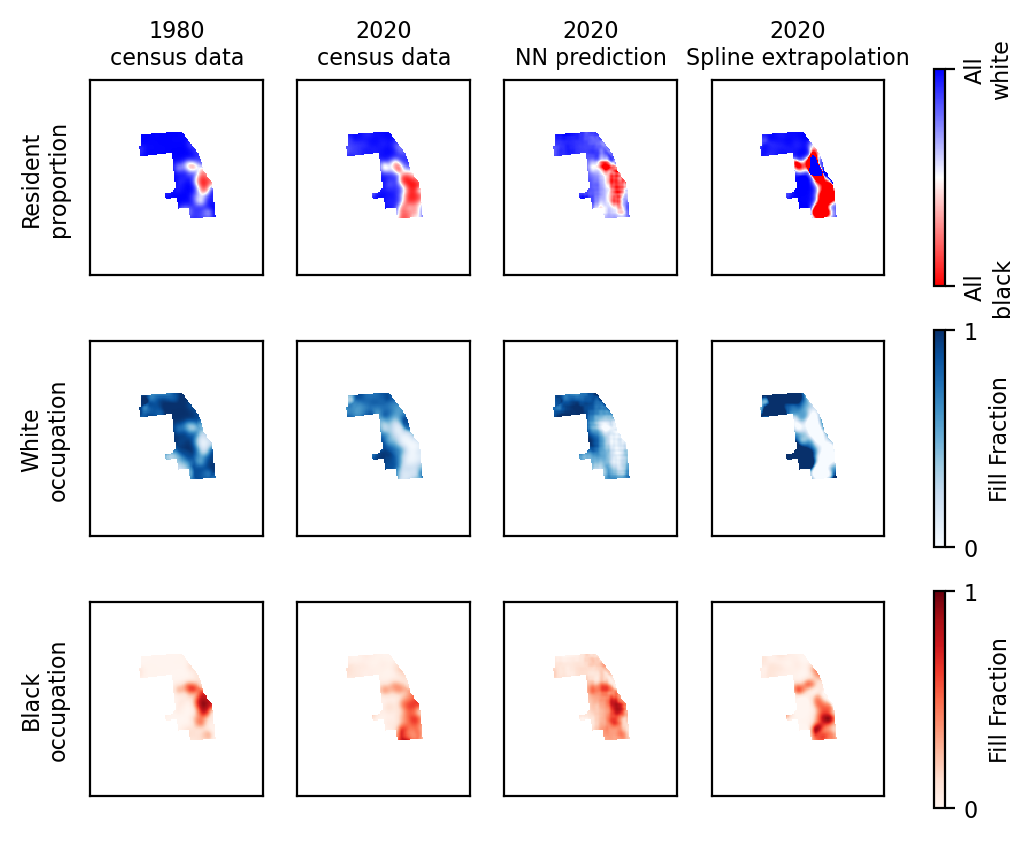

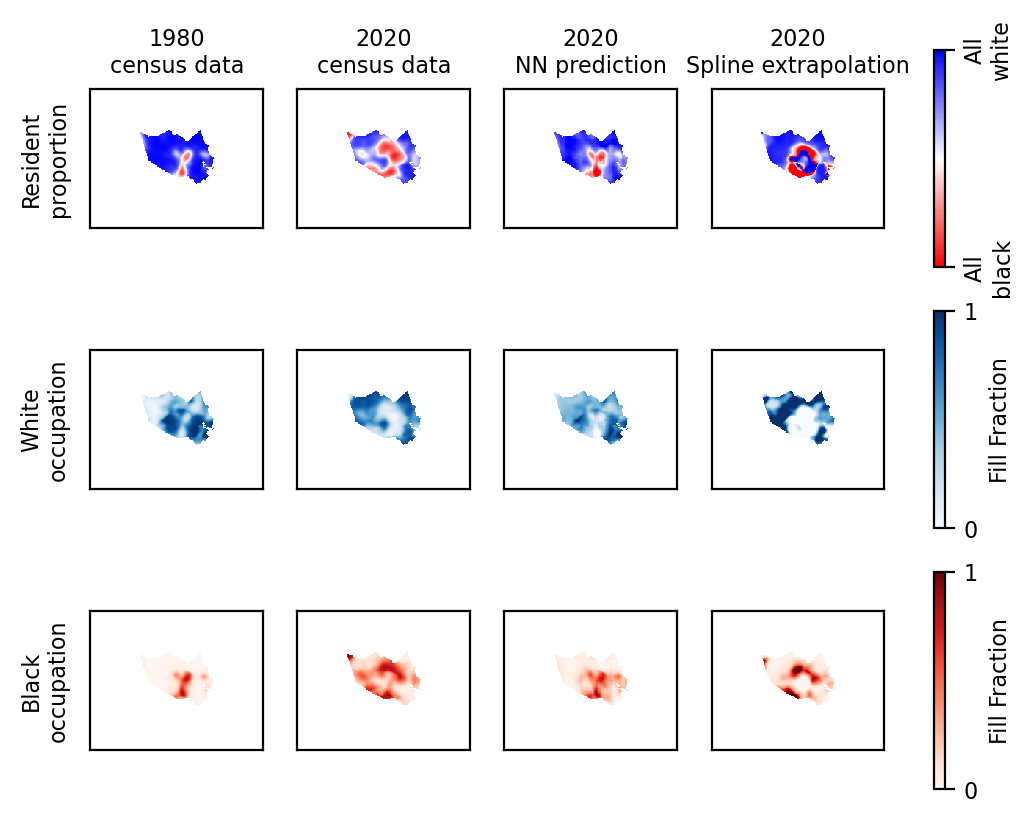

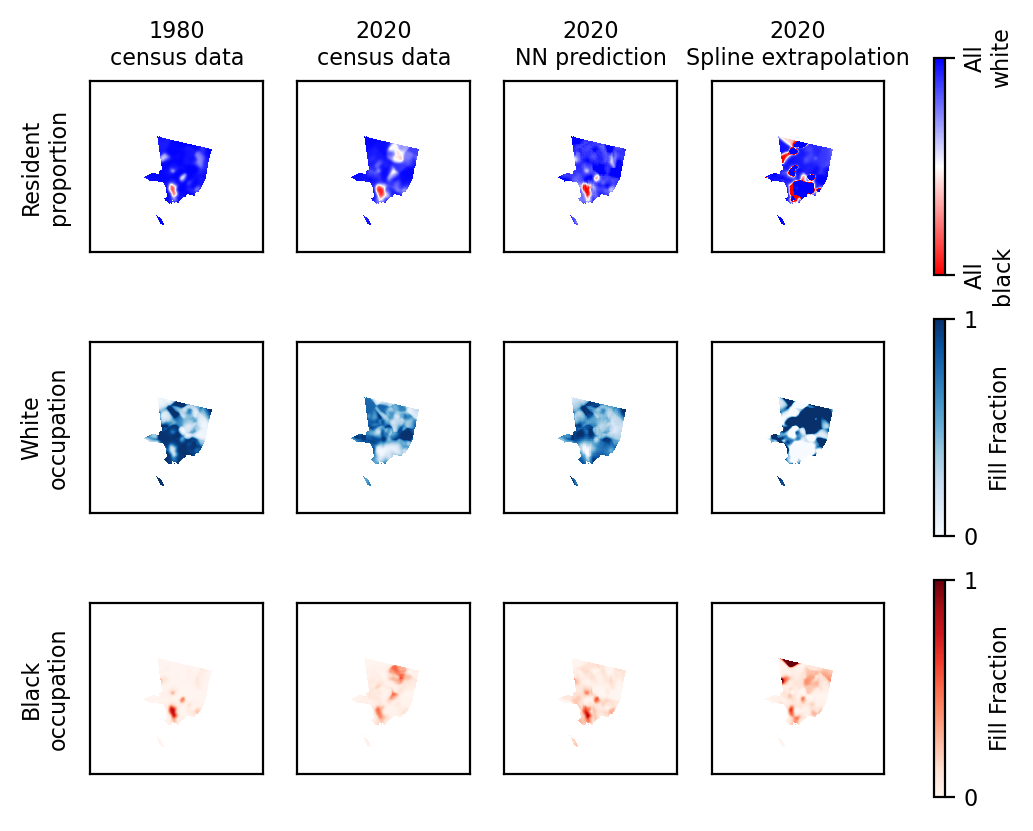

In [14]:
from census_nn import *
from pprint import pprint
import json

sub_df = df[df.objective == 'Fill fraction'].reset_index(drop=True)
model = os.path.basename(sub_df.loc[sub_df.val_loss.argmin(), 'path'])

with open(f'models/{model}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

model = get_model(config['model'])
model.to(device)
model.eval();

make_predictions_plot(model, 'Georgia_Fulton', config['dataset']['kwargs']);
make_predictions_plot(model, 'Illinois_Cook', config['dataset']['kwargs']);
make_predictions_plot(model, 'Texas_Harris', config['dataset']['kwargs']);
make_predictions_plot(model, 'California_Los Angeles', config['dataset']['kwargs']);